In [2]:
import numpy as np
import pickle
import h5py
import pandas as pd
from google.colab import drive
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import time
import math
import random
import matplotlib.pyplot as plt

In [3]:
%%capture
!pip install torch_geometric

A note on sources: While implementation of STGCN is my own interpretation of Yu et al, I ran into problems at a few points, and referenced the implementation below for debugging and clarification purposes:

https://github.com/FelixOpolka/STGCN-PyTorch/blob/master/stgcn.py

#1. Preparing the Data

In [4]:
# Connect to Google Drive
drive.mount('/content/drive', force_remount=True)
checkpoint_path = "/content/drive/MyDrive/checkpoints/stgcn_2.pth"

Mounted at /content/drive


In [5]:

# Load the HDF5 file
with h5py.File("/content/drive/MyDrive/data/metr-la.h5", "r") as f:
    data = f['df']

    # Get sensor ids, convert out of byte form (207)
    sensor_ids = np.array(data['axis0'][:]).astype(str)

    # # Get timestamps (34272)
    timestamps = pd.to_datetime(data['axis1'][:], unit='ns')

    # Load speed values (full dataset - (34272, 207))
    speed_values = data['block0_values'][:]

# Create a DataFrame with timestamps as index and sensor IDs as columns
df = pd.DataFrame(speed_values, index=timestamps, columns=sensor_ids)


In [6]:
# Load Adjacency Matrix
with open("/content/drive/MyDrive/data/adj_mx.pkl", "rb") as f:
    # Get entire dataset
    adj_dataset = pickle.load(f, encoding="latin1")
    # Pull actual adjacency matrix (207, 207)
    A = adj_dataset[2]

In [7]:
# Normalize Adjacency matrix - https://people.orie.cornell.edu/dpw/orie6334/Fall2016/lecture7.pdf

def normalize_adj_mx(A):
  # TODOL: need doc string
  num_nodes = A.shape[0]
  degrees = np.sum(A, axis=1)
  sqrt_degrees = np.sqrt(degrees)
  # Ensure no divide by 0 (or near 0) - bound at 10e-6
  sqrt_degrees[sqrt_degrees <= 10e-6] = 10e-6
  sqrt_degrees_inv = 1 / sqrt_degrees
  D = np.diag(sqrt_degrees_inv)

  normalized = D @ A @ D

  return normalized


A = normalize_adj_mx(A)
A = torch.from_numpy(A)

In [8]:
def prepare_data(df):
  # TODO: need docstring
  # Convert to numpy array, doubles to singles
  X = df.to_numpy().astype(np.float32)
  # (timestamps, nodes) -> (timestamps, nodes, 1)
  X = np.expand_dims(X, axis=-1)
  # Convert to pytorch
  X = torch.from_numpy(X)
  # Normalize the data - [Source]: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
  means = X.mean(dim=(0, 2), keepdim=True)
  stds = X.std(dim=(0, 2), keepdim=True)
  # Normalize
  X = (X - means) / stds
  return (X, means, stds)

X, means, stds = prepare_data(df)
# Convert means / stds back to np array
means = means.numpy()
stds = stds.numpy()
X.shape

torch.Size([34272, 207, 1])

In [9]:
# Features (speed) for 12 time intervals (5 minute periods) used to predict future data
hist_time_steps = 12
# Actual features for the future - the 3 time intervals after the first 12 to be predicted
pred_time_steps = 9

In [10]:
# Split the data into train, validate, and test (80 / 10 /10)
split_idx_1 = int(0.8 * len(X))
split_idx_2 = int(0.9 * len(X))

X_train = X[:split_idx_1]
X_val = X[split_idx_1:split_idx_2]
X_test = X[split_idx_2:]

In [11]:

def dataloader(X, hist_time_steps, pred_time_steps, shuffle=False):
  """
  Prepares historical and future feature datasets from time-series data.

  Args:
      X (np.ndarray): Input time-series data of shape (N, 207, 1).
      hist_time_steps (int): Number of historical time steps to consider.
      pred_time_steps (int): Number of future time steps to predict.
      shuffle (bool, optional): Whether to shuffle the dataset. Defaults to False.

  Returns:
      Tuple[torch.Tensor, torch.Tensor]:
          - Historical features of shape (N - (hist_time_steps + pred_time_steps - 1), hist_time_steps, 207, 1).
          - Future features of shape (N - (hist_time_steps + pred_time_steps - 1), pred_time_steps, 207, 1).

  NOTE: Used ChatGPT to generate this docstring due to time constraints. I
  hope this is acceptable as it was used simply as a finishing touch for
  documentation readablity.
  """
  t_steps = X.shape[0]

  prev_features = []
  future_features = []

  # Combined window
  combined_window = hist_time_steps + pred_time_steps

  for i in range(t_steps - combined_window + 1):
    prev_features.append(X[i:i+hist_time_steps])
    future_features.append(X[i+hist_time_steps: i+hist_time_steps+pred_time_steps])

  # Convert lists to np arrays - faster than directly converting to tensor
  prev_features = np.array(prev_features)
  future_features = np.array(future_features)

  # Apply shuffling if required
  if shuffle:
      # Generates a set of shuffled indices
      indices = np.random.permutation(prev_features.shape[0])
      # Shuffles historical data
      prev_features = prev_features[indices]
      # Shuffles future data
      future_features = future_features[indices]


  # Return np arrays as Pytorch tensors)
  return (torch.from_numpy(prev_features), torch.from_numpy(future_features))


In [12]:
# Create the train / validate / test datasets

# These aren't strictly features/labels, but X/Y notation is easy to follow :)
X_train, Y_train = dataloader(X_train, hist_time_steps, pred_time_steps, shuffle=True)
X_val, Y_val = dataloader(X_val, hist_time_steps, pred_time_steps)
X_test, Y_test = dataloader(X_test, hist_time_steps, pred_time_steps)

In [13]:
print(X_train.dtype, Y_train.dtype)
print(X_val.dtype, Y_val.dtype)
print(X_test.dtype, Y_test.dtype)

torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32


# 2. Define the Model

In [14]:
class TempGatedConv(nn.Module):
  """
  A Temporal Gated Convolutional Layer

  For first use,
  """
  def __init__(self, in_channels, out_channels, kernel_size):
    super(TempGatedConv, self).__init__()
    self.out_channels = out_channels
    # Pass two sets of C=64 feature maps to the GLU
    # Note:  padding=kernel_size // 2 preserves time dimension
    self.conv1 = nn.Conv1d(in_channels, out_channels * 2, kernel_size, padding=kernel_size // 2)
    # Gated linear unit via PyTorch
    self.glu = nn.GLU(dim=1)

  def forward(self, x):
      # (B, N, S, F) -> (B * N, F, S) - removes spatial component essentially
      batch_size, n_nodes, n_steps, n_features = x.size()
      x = x.permute(0, 1, 3, 2)
      x = x.contiguous().view(batch_size * n_nodes, n_features, n_steps)

      # Fixes different device error
      x = x.to(self.conv1.weight.device)
      # apply first conv
      out = self.conv1(x)
      # apply glu
      out = self.glu(out)

      # Undo original transformations
      out = out.view(batch_size, n_nodes, self.out_channels, n_steps)
      out = out.permute(0, 1, 3, 2)

      return out

In [15]:
from torch_geometric.nn import GraphConv
from torch_geometric.utils import dense_to_sparse

class SpatialGraphConv(nn.Module):
    """
    A spatial graph convolutional layer using PyTorch Geometric.
    This applies graph convolution without any temporal dependencies.

    Learned about PyTorch permute here:
      https://pytorch.org/docs/stable/generated/torch.permute.html
    """
    def __init__(self, in_channels, out_channels, adj_matrix):
        super(SpatialGraphConv, self).__init__()

        self.adj_matrix = adj_matrix

        # Convert adjacency matrix to edge index format for PyG
        self.edge_idx, self.edge_weights = dense_to_sparse(self.adj_matrix)

        # Define Graph Convolution layer (Spatial)
        self.conv = GraphConv(in_channels, out_channels)

    def forward(self, x):
      """
      Forward pass for spatial graph convolution.
      Expected input shape: (batch, num_nodes, timesteps, features)
      """
      # Ensure everything is on correct device
      edge_idx = self.edge_idx.to(x.device)
      edge_weights = self.edge_weights.to(x.device)


      # Merge the time dimension to isolate spatial dimension
      batch_size, n_nodes, n_steps, n_features = x.shape
      x = x.permute(0, 2, 1, 3)
      x = x.reshape(batch_size * n_steps, n_nodes, n_features)

      # Graph conv layer
      out = self.conv(x, edge_idx, edge_weights)

      # Reset to original shape (https://www.geeksforgeeks.org/reshaping-a-tensor-in-pytorch/)
      out = out.reshape(batch_size, n_steps, n_nodes, -1).permute(0, 2, 1, 3)

      return out


In [16]:
class STConvBlock(nn.Module):
  """
  A single spatial-temporal convolutional (ST-Conv) block made up of
  two Temporal Gated Convolution Layers, with a Spatial Graph Convolution
  Layer in Between

  "Layer normalization is utilized within every ST-Conv block to prevent overfitting"
  according to paper, so add it here


  NOTE ON SOURCES:
    Referenced https://github.com/FelixOpolka/STGCN-PyTorch/blob/master/stgcn.py
    to learn about adding theta parameter - network wasn't working and found
    that this fixed it
  """
  def __init__(self, in_channels, out_channels, adj_matrix, kernel_size):
    super(STConvBlock, self).__init__()

    # Dropout should fix overfitting
    self.dropout = nn.Dropout(p=0.35)

    # Temporal Gated Block from earlier
    self.temp_conv1 = TempGatedConv(in_channels, out_channels, kernel_size)

    # Layer norm via PyTorch
    self.norm1 = nn.LayerNorm(out_channels)

    # Spatial Graph Convolution (16 out channels defined in Yu. et al)
    self.space_conv = SpatialGraphConv(out_channels, 16, adj_matrix)

    # Via Kipf & Welling: Theta is a matrix of filter parameters
    # we can just use a simple linear layer to add in these weights
    self.theta = nn.Linear(16, 16)

    # Layer norm
    self.norm2 = nn.LayerNorm(16)

    # Second Temporal Gated Block
    self.temp_conv2 = TempGatedConv(16, out_channels, kernel_size)

    # Layer norm
    self.norm3 = nn.LayerNorm(out_channels)

    # Apply a final ReLu
    self.relu = nn.ReLU()



  def forward(self, x):
    # Apply each layer sequentially without dropouts in bewtween
    out = self.norm1(self.temp_conv1(x))
    out = self.dropout(out)
    out = self.norm2(self.space_conv(out))
    out = self.dropout(out)
    out = self.theta(out)
    out = self.norm3(self.temp_conv2(out))
    out = self.dropout(out)

    return self.relu(out)




In [17]:
class ST_GCN(nn.Module):
  """
  Final model to use. This is simply two of the pre-defined ST-Conv Blocks,
  followed by a linear layer with the dimension of the number of time intervals
  we want to predict (we use 9 in accordance with Yu et al.)
  """

  def __init__(self, adj_matrix, n_features, n_timesteps_input, n_timesteps_output, kernel_size=3):
    # default kernel size is 3 in accordance with Yu et al
    super(ST_GCN, self).__init__()

    n_nodes = adj_matrix.shape[0]
    # Two St-Conv Blocks (channel sizes as define in Yu et al)
    # First block has 1 input channel (speed)
    self.st_block1 = STConvBlock(n_features, 64, adj_matrix, kernel_size)
    self.st_block2 = STConvBlock(64, 64, adj_matrix, kernel_size)
    # Output Layer (output dim is number of time sequences to predict)
    self.fc = nn.Linear(64 * n_timesteps_input, n_timesteps_output)

  def forward(self, x, adj_matrix):

    # Apply each block
    out = self.st_block1(x)
    out = self.st_block2(out)

    # Reshape input to fit into our fc layer
    batch_size, n_nodes, n_steps, n_features = out.shape
    out = out.reshape(batch_size, n_nodes, n_steps * n_features)

    # Get results
    out = self.fc(out)
    return out




In [18]:
# Model parameters
lr = 10e-3
batch_size = 50
epochs = 50

In [19]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model = ST_GCN(A, 1, hist_time_steps, pred_time_steps).to(device)
# Send adjacency matrix (already normalized) to device
A = A.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

# From paper: The initial learning rate is 10-3 with a decay rate of 0.7 after every 5 epochs
# https://pytorch.org/docs/stable/optim.html
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

loss_criterion = nn.MSELoss()


In [20]:
# Load Existing Model (checkpoints the training process)
# SOURCE: Used ChatGPT since this did not affect the model itself, but allowed me to not lose progress when training
start_epoch = 0
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # resume from the next epoch
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found, starting training from scratch.")

Resuming training from epoch 50


In [21]:
def train_epoch(X_train, Y_train, batch_size, A):
    """
    Training a single epoch
    """
    total_loss = []
    for i in range(0, X_train.shape[0], batch_size):
        model.train()
        optimizer.zero_grad()

        X = X_train[i:i + batch_size]
        y = Y_train[i:i + batch_size]

        X = X.to(device)
        y = y.to(device)

        pred = model(X, A)

        loss = loss_criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.detach().cpu().numpy())

    return sum(total_loss)/len(total_loss)

In [22]:
def val_epoch(X_val, Y_val, batch_size, A):
    """
    This validation method (inspired by https://github.com/FelixOpolka/STGCN-PyTorch/blob/master/stgcn.py)
    allows us to track the progress of the model as we train it, making
    overfitting evident (training loss and validation loss would stray)
    """
    # Put it into testing mode, and we don't need gradients
    model.eval()
    total_loss = []
    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):

          X = X_val[i:i + batch_size]
          y = Y_val[i:i + batch_size]


          X = X.to(device)
          y = y.to(device)
          pred = model(X, A)

          loss = loss_criterion(pred, y)

          losses.append(loss.detach().cpu().item())
    return sum(losses) / len(losses)


In [23]:
# Swapping axes and removing 4th dim in Y - some last second adjustments to fix model errors
X_train = np.swapaxes(X_train, 1, 2)
Y_train = np.swapaxes(Y_train, 1, 2)
Y_train = np.squeeze(Y_train, axis=-1)

X_val = np.swapaxes(X_val, 1, 2)
Y_val = np.swapaxes(Y_val, 1, 2)
Y_val = np.squeeze(Y_val, axis=-1)

X_test = np.swapaxes(X_test, 1, 2)
Y_test = np.swapaxes(Y_test, 1, 2)
Y_test = np.squeeze(Y_test, axis=-1)


In [24]:
"""
RUN THIS CODE BLOCK TO TRAIN MODEL
"""
# Track both training and validation loss
train_loss = []
val_losses = []

for epoch in range(start_epoch, epochs):
    # Timer
    start_time = time.time()

    # Train
    loss = train_epoch(X_train, Y_train, batch_size, A)
    train_loss.append(loss)

    # Validate
    val_loss = val_epoch(X_val, Y_val, batch_size, A)
    val_losses.append(val_loss)

    # Clear GPU memory
    torch.cuda.empty_cache()

    final_loss_train = training_losses[-1]
    final_loss_val = val_losses[-1]
    # Logging
    print("Epoch completed")
    print("Elapsed time:", time.time() - start_time, "seconds")
    if (epoch % 10) == 0:
        print(f"Completed epoch: {epoch} of {epochs}. Loss = {loss}")


    print("Training loss:", final_loss_train)
    print("Validation loss:", final_loss_val)

    # Plot
    plt.plot(training_losses, label="Training loss")
    plt.plot(validation_losses, label="Validation loss")
    plt.legend()
    plt.show()

    # Save a checkpoint after each epoch (Used ChatGPT since it doesn't affect the model itself - just for progres)
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, checkpoint_path)

In [30]:
def eval(model, X_test, Y_test):
    """
    Evaluation function. Produces the three metrics used in Yu. et al.
    Also generates graphs of predictions versus real data
    """

    model.eval()
    with torch.no_grad():
        abs_error = []
        perc_error = []
        sq_error = []
        real_vals = {}
        pred_vals = {}

        # Select 4 random sensors
        num_sensors = Y_test.shape[1]
        random_sensors = random.sample(range(num_sensors), 4)


        # Grab 4 random sensors
        for sensor in random_sensors:
            real_vals[sensor] = []
            pred_vals[sensor] = []

        for i in range(0, X_test.shape[0], batch_size):
            input_batch = X_test[i:i+batch_size].to(device)
            target_batch = Y_test[i:i+batch_size].to(device)

            result = model(input_batch, A)

            # We must undo our earlier normalization process
            denormed_result = result.detach().cpu().numpy() * stds[0] + means[0]
            denormed_target = target_batch.detach().cpu().numpy() * stds[0] + means[0]

            # Apply mask to avoid exploding errors for very low speeds
            mask = denormed_target >= 1
            target_masked = denormed_target[mask]
            result_masked = denormed_result[mask]

            error = target_masked - result_masked
            percent_error = np.abs(error) / target_masked
            squared_error = np.square(error)

            # Add to one long list of errors to later average
            abs_error.extend(np.abs(error).tolist())
            perc_error.extend(percent_error.tolist())
            sq_error.extend(squared_error.tolist())

            # Iterate through each sensor and get prediction versus real
            for sensor in selected_sensors:
                real_vals[sensor].append(denormed_target[:, sensor, :])
                pred_vals[sensor].append(denormed_result[:, sensor, :])

        mae_error = np.mean(np.array(abs_error))
        mape_error = np.mean(np.array(perc_error)) * 100  # Convert from decimal to %
        rmse_error = np.sqrt(np.mean(np.array(sq_error)))


        # Plots for the four random sensors (used GPT to help me with subplots)
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()

        for idx, sensor in enumerate(random_sensors):
            real_vals = np.concatenate(real_vals[sensor], axis=0).flatten()
            pred_vals = np.concatenate(pred_vals[sensor], axis=0).flatten()

            axes[idx].plot(real_vals, label='True Speed')
            axes[idx].plot(pred_vals, label='Predicted Speed')
            axes[idx].set_xlabel('Time')
            axes[idx].set_ylabel('Speed')
            axes[idx].set_title(f'Sensor {sensor}: Predicted vs. True Speed')
            axes[idx].legend()

        plt.tight_layout()
        plt.show()

        return mae_error, mape_error, rmse_error

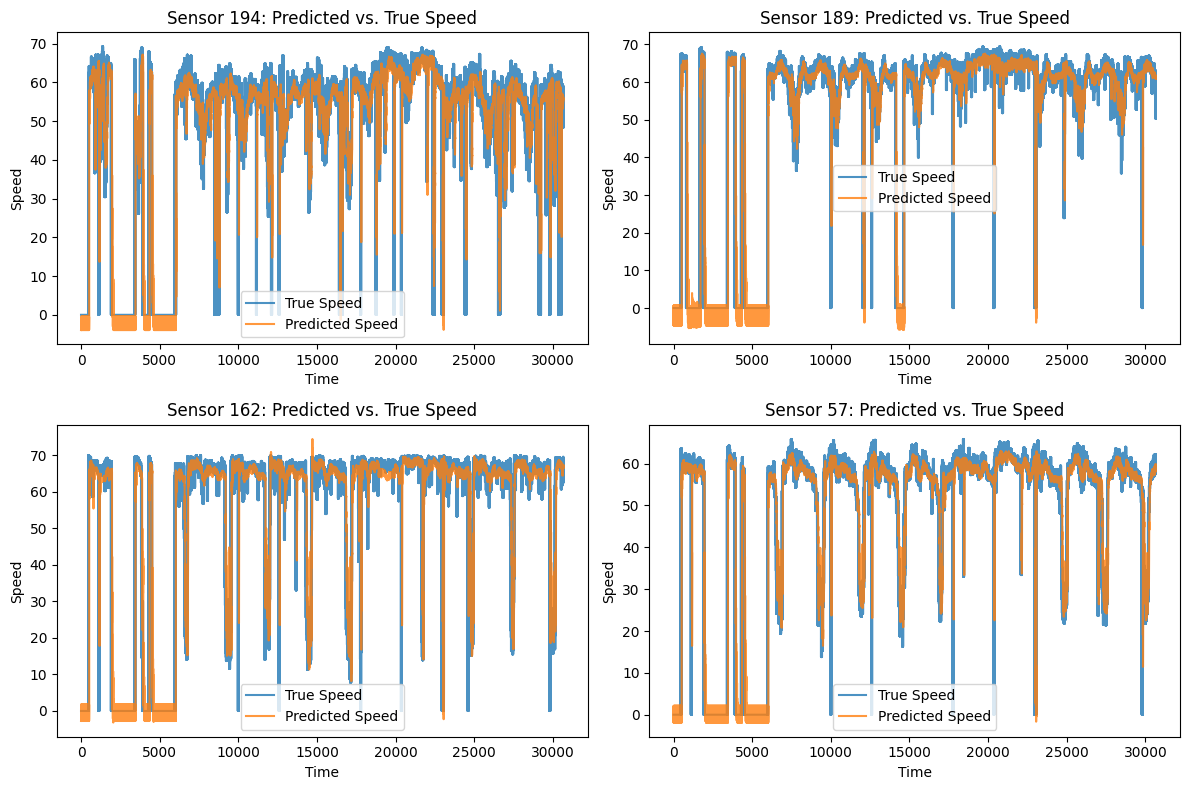

In [31]:
mse, mape, rmse = eval(model, X_test, Y_test)


In [29]:
print(mse, mape, rmse)

4.465822339366818 10.79695796998969 9.232322201013236
